In [1]:
!pip install --quiet pymoo

In [2]:
import numpy as np
import time

from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.algorithms.moo.nsga3 import NSGA3
from pymoo.algorithms.moo.unsga3 import UNSGA3
from pymoo.util.ref_dirs import get_reference_directions
from pymoo.mcdm.pseudo_weights import PseudoWeights
from pymoo.optimize import minimize
from pymoo.termination import get_termination

from mrta.utils import (
    convert_chromosome_to_allocation,
    generate_random_chromosome,
    plot_pseudo_weight_choice,
    plot_F_history,
    plot_hypervolume_history,
    plot_running_metrics,
    constraint_satisfactory,
)
from mrta.multiple_robot_task_allocation_model import (
    MultipleRobotTaskAllocationProblem,
    MultipleRobotMultipleRobotTaskAllocationSampling,
    MultipleRobotMultipleRobotTaskAllocationCrossover,
    MultipleRobotMultipleRobotTaskAllocationMutation,
    MultipleRobotMultipleRobotTaskAllocationDuplicateElimination,
)

In [3]:
r99 = [
(6,  4),
(15, 15),
(24, 18),
(33, 12),
(48, 12),
(57, 14),
(67, 10),
(77, 10),
(86, 15),
( 6, 21),
(17, 26),
(23, 25),
(32, 35),
(43, 23),
(55, 35),
(65, 36),
(78, 39),
(87, 35),
( 3, 53),
(12, 44),
(28, 53),
(33, 49),
(47, 46),
(55, 52),
(64, 50),
(71, 57),
(87, 57),
( 4, 72),
(15, 78),
(22, 70),
(34, 71),
(42, 79),
(54, 77),
(66, 79),
(78, 67),
(87, 73),
( 7, 81),
(17, 95),
(26, 98),
(32, 97),
(43, 88),
(57, 89),
(64, 85),
(78, 83),
(83, 98),
 (  5, 109),
 ( 13, 111),
 ( 25, 102),
 ( 38, 119),
 ( 46, 107),
 ( 58, 110),
 ( 67, 110),
 ( 74, 113),
 ( 88, 110),
 (  2, 124),
 ( 17, 134),
 ( 23, 129),
 ( 36, 131),
 ( 42, 137),
 ( 53, 123),
 ( 63, 135),
 ( 72, 134),
 ( 87, 129),
 (  2, 146),
 ( 16, 147),
 ( 25, 153),
 ( 38, 155),
 ( 42, 158),
 ( 57, 154),
 ( 66, 151),
 ( 73, 151),
 ( 86, 149),
 (  5, 177),
 ( 13, 162),
 ( 25, 169),
 ( 35, 177),
 ( 46, 172),
 ( 54, 166),
 ( 65, 174),
 ( 73, 161),
 ( 86, 162),
 (  2, 195),
 ( 14, 196),
 ( 28, 189),
 ( 38, 187),
 ( 46, 195),
 ( 57, 194),
 ( 63, 188),
 ( 77, 193),
 ( 85, 194),
 (  8, 211),
 ( 12, 217),
 ( 22, 210),
 ( 34, 216),
 ( 47, 203),
 ( 58, 213),
 ( 66, 206),
 ( 78, 210),
 ( 85, 204)
]

In [4]:

eil51 = [(37 ,52), # depot
        (49 ,49),
        (52 ,64),
        (20 ,26),
        (40 ,30),
        (21 ,47),
        (17 ,63),
        (31 ,62),
        (52 ,33),
        ( 51, 21),
        ( 42, 41),
        ( 31, 32),
        ( 5 ,25),
        ( 12, 42),
        ( 36, 16),
        ( 52, 41),
        ( 27, 23),
        ( 17, 33),
        ( 13, 13),
        ( 57, 58),
        ( 62, 42),
        ( 42, 57),
        ( 16, 57),
        ( 8 ,52),
        ( 7 ,38),
        ( 27, 68),
        ( 30, 48),
        ( 43, 67),
        ( 58, 48),
        ( 58, 27),
        ( 37, 69),
        ( 38, 46),
        ( 46, 10),
        ( 61, 33),
        ( 62, 63),
        ( 63, 69),
        ( 32, 22),
        ( 45, 35),
        ( 59, 15),
        ( 5 ,6),
        ( 10, 17),
        ( 21, 10),
        ( 5 ,64),
        ( 30, 15),
        ( 39, 10),
        ( 32, 39),
        ( 25, 32),
        ( 25, 55),
        ( 48, 28),
        ( 56, 37),
        (30, 40)]

In [5]:
eil76 = [
(22, 22),
(36, 26),
(21, 45),
(45, 35),
(55, 20),
(33, 34),
(50, 50),
(55, 45),
(26, 59),
 (40, 66),
 (55, 65),
 (35, 51),
 (62, 35),
 (62, 57),
 (62, 24),
 (21, 36),
 (33, 44),
 (9, 56),
 (62, 48),
 (66, 14),
 (44, 13),
 (26, 13),
 (11, 28),
 (7, 43),
 (17, 64),
 (41, 46),
 (55, 34),
 (35, 16),
 (52, 26),
 (43, 26),
 (31, 76),
 (22, 53),
 (26, 29),
 (50, 40),
 (55, 50),
 (54, 10),
 (60, 15),
 (47, 66),
 (30, 60),
 (30, 50),
 (12, 17),
 (15, 14),
 (16, 19),
 (21, 48),
 (50, 30),
 (51, 42),
 (50, 15),
 (48, 21),
 (12, 38),
 (15, 56),
 (29, 39),
 (54, 38),
 (55, 57),
 (67, 41),
 (10, 70),
 (6, 25),
 (65, 27),
 (40, 60),
 (70, 64),
 (64, 4),
 (36, 6),
 (30, 20),
 (20, 30),
 (15, 5),
 (50, 70),
 (57, 72),
 (45, 42),
 (38, 33),
 (50, 4),
 (66, 8),
 (59, 5),
 (35, 60),
 (27, 24),
 (40, 20),
 (40, 37),
 (40, 40)
]

In [6]:
pois = eil51
r = 3 # number of robots
n = len(pois)
C = np.zeros((n,n))

def distance(a, b):
    return np.linalg.norm([a[0] - b[0], a[1] - b[1]])

for i in range(0, n):
    for j in range(0, n):
        C[i,j] = distance(pois[i], pois[j])

print('Distance Matrix is:\n')
print(np.round(C,4))

mission_table = C[1:, 1:]
print('Mission Table is:\n')
print(np.round(mission_table,4))
print("size: ", mission_table.shape)

robot_to_mission_start_table = np.tile(C[0, 1:], (r, 1))
print('Robot to Mission Start Table is:\n')
print(np.round(robot_to_mission_start_table,4))
print("size: ", robot_to_mission_start_table.shape)

robot_to_mission_end_table = np.tile( C[1:, 0].T, (r, 1))
print('Robot to Mission End Table is:\n')
print(np.round(robot_to_mission_end_table,4))
print("size: ", robot_to_mission_end_table.shape)

Distance Matrix is:

[[ 0.     12.3693 19.2094 ... 26.4008 24.2074 13.8924]
 [12.3693  0.     15.2971 ... 21.0238 13.8924 21.0238]
 [19.2094 15.2971  0.     ... 36.2215 27.2947 32.5576]
 ...
 [26.4008 21.0238 36.2215 ...  0.     12.0416 21.6333]
 [24.2074 13.8924 27.2947 ... 12.0416  0.     26.1725]
 [13.8924 21.0238 32.5576 ... 21.6333 26.1725  0.    ]]
Mission Table is:

[[ 0.     15.2971 37.0135 ... 21.0238 13.8924 21.0238]
 [15.2971  0.     49.679  ... 36.2215 27.2947 32.5576]
 [37.0135 49.679   0.     ... 28.0713 37.6431 17.2047]
 ...
 [21.0238 36.2215 28.0713 ...  0.     12.0416 21.6333]
 [13.8924 27.2947 37.6431 ... 12.0416  0.     26.1725]
 [21.0238 32.5576 17.2047 ... 21.6333 26.1725  0.    ]]
size:  (50, 50)
Robot to Mission Start Table is:

[[12.3693 19.2094 31.0644 22.2036 16.7631 22.8254 11.6619 24.2074 34.0147
  12.083  20.8806 41.8688 26.9258 36.0139 18.6011 30.6757 27.5862 45.793
  20.8806 26.9258  7.0711 21.587  29.     33.1059 18.868   8.0623 16.1555
  21.3776 32.6497

In [7]:
def get_previous_best_allocation(self, robot_num, mission_num):
    if (
        self.previous_best_allocation is None
        or robot_num != self.previous_robot_num
        or mission_num != self.previous_mission_num
    ):
        previous_best_allocation = generate_random_chromosome(
            robot_num, mission_num
        )
    else:
        previous_best_allocation = self.previous_best_allocation
    return previous_best_allocation

In [8]:
mission_num = n-1
robot_num = r

population_size = 10
generation_num = 2000

previous_best_allocation = None # np.array(
# [1, 15, 23, 50, 59, 68, 69, 79, 78, 67, 70, 61, 51, 58, 64, 82, 92, 94, 96, 45, 12, 13, 22, 29, 36, 48, 47, 91, 90, 89, 80, 71, 72, 35, 8, 4, 14, 6, 7, 3, 5, 28, 37, 55, 66, 88, 87, 95, 93, 97, 83, 81, 73, 54, 62, 53, 44, 77, 86, 85, 84, 74, 75, 65, 60, 33, 25, 24, 56, 57, 63, 76, 42, 49, 52, 43, 34, 16, 40, 32, 39, 38, 30, 41, 31, 0, 10, 20, 21, 11, 17, 26, 27, 46, 19, 18, 9, 2, 20, 15, 22, 11, 17, 1, 12]

    # [14, 15, 33, 68, 59, 60, 69, 79, 67, 76, 70, 42, 23, 22, 53, 72, 92, 83, 74, 47, 12, 2, 32, 36, 29, 27, 51, 61, 91, 89, 80, 71, 44, 26, 8, 4, 1, 6, 7, 3, 5, 17, 37, 55, 66, 88, 96, 95, 93, 87, 73, 82, 64, 54, 63, 62, 9, 52, 97, 85, 84, 46, 58, 94, 90, 49, 24, 21, 56, 57, 75, 78, 77, 86, 50, 43, 25, 16, 40, 48, 39, 38, 30, 41, 31, 0, 10, 20, 35, 28, 11, 65, 81, 45, 19, 18, 13, 34, 20, 15, 22, 11, 17, 12, 1]

#     [20, 0, 48, 32, 28, 37, 31, 43, 42, 13, 14, 27, 19, 18, 33, 34, 1, 44, 10, 3, 8, 7, 47, 36, 9, 4, 12, 23, 21, 6, 24, 29, 26, 49, 45, 16, 2, 35, 15, 40, 17, 38, 39, 11, 22, 41, 5, 46, 25, 30, 17, 16, 17]
    # )

# print(previous_best_allocation.shape)



algorithm = NSGA2(
    pop_size=population_size,
    sampling=MultipleRobotMultipleRobotTaskAllocationSampling(
        previous_best_allocation_results=previous_best_allocation,
    ),
    crossover=MultipleRobotMultipleRobotTaskAllocationCrossover(),
    mutation=MultipleRobotMultipleRobotTaskAllocationMutation(),
    save_history=False,  # set True to save history for visualization, default should be False
    eliminate_duplicates=MultipleRobotMultipleRobotTaskAllocationDuplicateElimination(),
)

# ref_dirs = get_reference_directions("das-dennis", 3, n_partitions=12)
# algorithm = NSGA3(
#     pop_size=population_size,
#     sampling=MultipleRobotMultipleRobotTaskAllocationSampling(
#         previous_best_allocation_results=previous_best_allocation,
#         robot_to_mission_skill_fulfillment_lut=robot_to_mission_skill_fulfillment_lut,
#         mission_priorities=mission_priorities,
#     ),
#     crossover=MultipleRobotMultipleRobotTaskAllocationCrossover(),
#     mutation=MultipleRobotMultipleRobotTaskAllocationMutation(),
#     save_history=False,  # set True to save history for visualization, default should be False
#     eliminate_duplicates=MultipleRobotMultipleRobotTaskAllocationDuplicateElimination(),
#     ref_dirs=ref_dirs,
# )

# ref_dirs = get_reference_directions("das-dennis", 3, n_partitions=6)
# algorithm = UNSGA3(
#     pop_size=population_size,
#     sampling=MultipleRobotMultipleRobotTaskAllocationSampling(
#         previous_best_allocation_results=previous_best_allocation,
#         robot_to_mission_skill_fulfillment_lut=robot_to_mission_skill_fulfillment_lut,
#         mission_priorities=mission_priorities,
#     ),
#     crossover=MultipleRobotMultipleRobotTaskAllocationCrossover(),
#     mutation=MultipleRobotMultipleRobotTaskAllocationMutation(),
#     save_history=False,  # set True to save history for visualization, default should be False
#     eliminate_duplicates=MultipleRobotMultipleRobotTaskAllocationDuplicateElimination(),
#     ref_dirs=ref_dirs,
# )
 
problem = MultipleRobotTaskAllocationProblem(
    robot_num=robot_num,
    mission_num=mission_num,
    # robot_max_velocity=robot_max_velocities,
    robot_to_mission_start_distance_lut=robot_to_mission_start_table,
    robot_to_mission_end_distance_lut=robot_to_mission_end_table,
    mission_end_to_mission_start_distance_lut=mission_table,
    # mission_priorities=mission_priorities,
    # robot_to_mission_skill_fulfillment_lut=robot_to_mission_skill_fulfillment_lut,
)
termination = get_termination("n_gen", generation_num)

In [9]:
experiment_times = 10

total_distance_list = []
distance_each_agent_list = []
process_time_list = []
standard_deviation_list = []
ans_list = []


for _ in range(experiment_times):
    start_time = time.time()
    res_nsga2 = minimize(
        problem, algorithm, termination, seed=int(time.time()), verbose=False
    )
    end_time = time.time()
    process_time = end_time - start_time
    process_time_list.append(process_time)

    results_nsga2 = res_nsga2.X[np.argsort(res_nsga2.F[:, 0])]

    ## Multi-Criteria Decision Making
    F_nsga2 = res_nsga2.F
    weights = np.array(
        [1.0, 0.0]
    )  # [fitness_total_sum, fitness_max_time_span, fitness_mission_priority]
    pseudo_weight = PseudoWeights(weights).do(F_nsga2)
    previous_best_allocation = results_nsga2[pseudo_weight]
    result = convert_chromosome_to_allocation(
        robot_num, mission_num, res_nsga2.X[pseudo_weight]
    )
    ans_list.append(result)
    traveled_distance_per_robot = problem.objective_func(result)
    distance_each_agent_list.append(traveled_distance_per_robot)
    standard_deviation_list.append(np.std(traveled_distance_per_robot))
    total_distance_list.append(sum(traveled_distance_per_robot))
    # for i in range(robot_num):
    #     print("Robot {} : {}, travel distance: {}".format(i, result[i], traveled_distance_per_robot[i]))
    print("Total traveled Distance: {}".format(problem.objective_func_total_sum(result)))

print("total_distance_list: ", total_distance_list)
print("min_distance: ", min(total_distance_list))
print("max_distance: ", max(total_distance_list))
print("average_distance: ", sum(total_distance_list) / len(total_distance_list))
print("average_process_time: ", sum(process_time_list) / len(process_time_list))

# choose the min total distance and print the distance of each agent
min_index = total_distance_list.index(min(total_distance_list))
print("min_distance_each_agent: ", distance_each_agent_list[min_index].tolist())
print("standard_deviation: ", standard_deviation_list[min_index])


Total traveled Distance: 685.0417581831414
Total traveled Distance: 698.1798329920855
Total traveled Distance: 644.4678667049664
Total traveled Distance: 753.5527666538891
Total traveled Distance: 760.0058764094251
Total traveled Distance: 712.7142993016964
Total traveled Distance: 742.0016383951954
Total traveled Distance: 760.9614384441381
Total traveled Distance: 620.6798186932074
Total traveled Distance: 662.9541382210914
total_distance_list:  [685.0417581831414, 698.1798329920855, 644.4678667049664, 753.5527666538891, 760.0058764094251, 712.7142993016964, 742.0016383951954, 760.9614384441381, 620.6798186932074, 662.9541382210914]
min_distance:  620.6798186932074
max_distance:  760.9614384441381
average_distance:  704.0559433998836
average_process_time:  7.513636064529419
min_distance_each_agent:  [422.93377883418515, 14.142135623730951, 183.60390423529122]
standard_deviation:  167.69903181830887


In [13]:
# print(results_nsga2)
print(result)
# print(', '.join(map(str, results_nsga2[pseudo_weight])))

[array([9, 36, 45, 10, 2, 11, 39, 17, 38, 40, 42, 35, 44, 29, 24, 41, 22,
        23, 12, 15, 13, 43, 31, 8, 3, 47, 37, 28, 32, 7, 48, 14, 19, 27],
       dtype=object)
 array([20], dtype=object)
 array([25, 49, 30, 0, 18, 33, 34, 1, 26, 6, 4, 16, 21, 5, 46],
       dtype=object)                                           ]


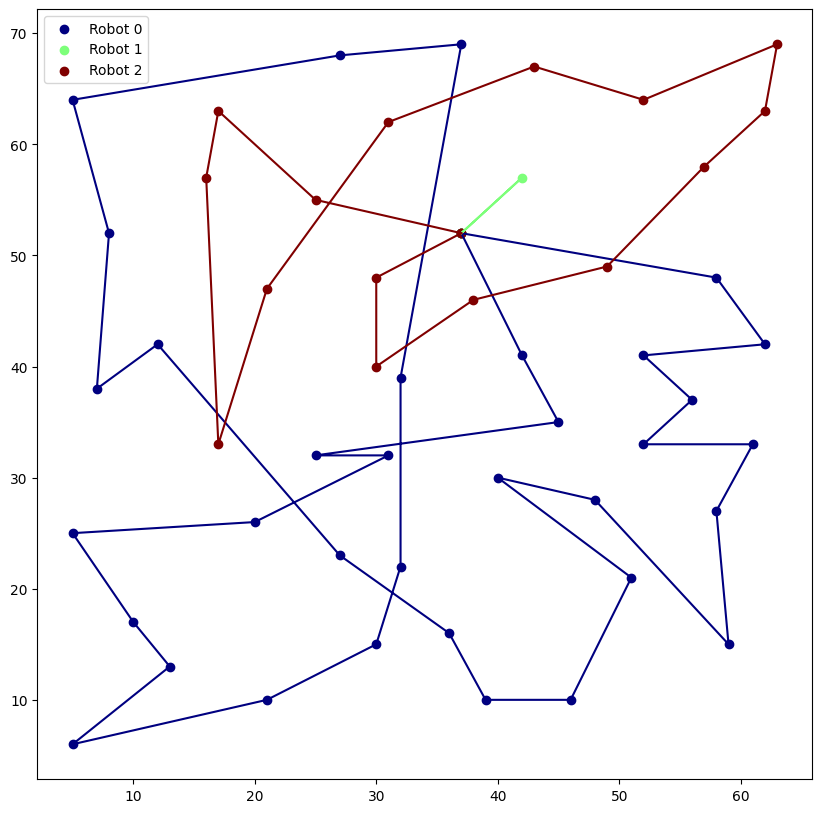

In [11]:
import matplotlib.pyplot as plt

result = ans_list[min_index]
# plot the path of each robot
plt.figure(figsize=(10, 10))
colors = plt.cm.jet(np.linspace(0, 1, len(result)))
for idx, agent in enumerate(result):
    agent = agent+1
    agent = np.insert(agent, 0, 0)
    agent = np.append(agent, 0)
    x = [pois[point][0] for point in agent]
    y = [pois[point][1] for point in agent]
    plt.scatter(x, y, color=colors[idx], label="Robot {}".format(idx))
    plt.legend()
    plt.plot(x, y, color=colors[idx])

In [12]:
Robot 0 : [14 15 33 68 59 60 69 79 67 76 70 42 23 22 53 72 92 83 74 47], travel distance: 847.0090138370551
Robot 1 : [12 2 32 36 29 27 51 61 91 89 80 71 44 26 8], travel distance: 647.8469461281892
Robot 2 : [4 1 6 7 3 5 17 37 55 66 88 96 95 93 87 73 82 64 54 63 62 9], travel distance: 843.6793877424462
Robot 3 : [52 97 85 84 46 58 94 90 49 24 21], travel distance: 791.6289566022078
Robot 4 : [56 57 75 78 77 86 50 43 25 16 40 48 39 38 30 41 31], travel distance: 653.9516286699571
Robot 5 : [0 10 20 35 28 11 65 81 45 19 18 13], travel distance: 582.0956266999932
Robot 6 : [34], travel distance: 212.8097742116184
Total traveled Distance: 4579.021333891467

Robot 0 : [2 3 15 34 42 59 68 69 76 78 79 70 61 32 22 31 51 50 65 47], travel distance: 665.5707716593624
Robot 1 : [5 6 18 46 36 38 48 49 58 91 89 80 71 53 19], travel distance: 597.4918058734872
Robot 2 : [8 0 12 4 7 16 33 29 44 55 86 87 88 94 93 74 73 72 64 62 63 54], travel distance: 668.7598072758145
Robot 3 : [35 95 97 96 84 92 82 81 90 52 43 14], travel distance: 643.41295950076
Robot 4 : [37 57 60 67 77 85 75 66 25 24 23 41 39 27 28 30 20], travel distance: 614.423925342788
Robot 5 : [9 10 11 21 13 40 83 56 45 26 17], travel distance: 424.8557958573098
Robot 6 : [1], travel distance: 45.60701700396552
Total traveled Distance: 3660.122082513488

Robot 0 : [1 12 39 50 59 68 69 67 78 79 70 61 51 58 64 82 92 74 66 56], travel distance: 634.5213299370716
Robot 1 : [13 14 22 16 23 48 47 91 90 89 80 71 72 46 2], travel distance: 568.6449643103163
Robot 2 : [4 7 6 5 3 11 28 38 76 87 88 97 95 93 85 83 81 73 63 62 53 44], travel distance: 646.4890986520023
Robot 3 : [77 94 96 84 86 75 65 33 24 25 15], travel distance: 560.7054535443427
Robot 4 : [45 57 54 55 60 49 52 43 34 42 40 32 37 36 30 41 31], travel distance: 579.7003585580145
Robot 5 : [0], travel distance: 28.42534080710379
Robot 6 : [20 19 21 10 9 26 27 35 29 18 17 8], travel distance: 311.4677384868331
Total traveled Distance: 3329.9542842956844

SyntaxError: invalid syntax (1477645648.py, line 1)

In [ ]:
optimal_chromosome = np.array([32, 11, 38, 5, 49, 10, 39, 33, 45, 15, 37, 17, 44, 42, 19, 40, 41, 13, 25, 18, 4, 47, 12, 46, 51, 27, 22, 2, 16, 50, 9, 30, 34, 21, 29, 20, 35, 36, 3, 28, 31, 8, 26, 7, 23, 43, 24, 14, 6, 48, 26, 24])-2
result = convert_chromosome_to_allocation(
    robot_num, mission_num, optimal_chromosome
)
traveled_distance_per_robot = problem.objective_func(result)
for i in range(robot_num):
    # result_priority = [mission_priorities[j] for j in result[i]]
    print("Robot {} : {}, travel distance: {}".format(i, result[i], traveled_distance_per_robot[i]))

IndexError: index 52 is out of bounds for axis 0 with size 52

In [ ]:
Robot 0 : [20 6 5 21 46 25 10 3 8 47 37 31 43 13 39 11 16 45 36 7 28 32 14 0 9 30], travel distance: 293.17624313338916
Robot 1 : [49 44 48 19 27 1 26 18 33 34 29 24 41 22 2 15 35 42 40 38 17 23 12 4], travel distance: 327.6053857632449